# AHEAD Beat perception

Original code by Pilou Bazin, based on the Stopping the AHEAD study (with Max Keuken, Sarah Kemp). Further edits by Atser Damsma.

## Project overview

Here we want to relate musical beat and interval perception assessed with an online experiment to structural connectivity and quantitative MRI differences in AHEAD subjects, in the putative networks involved in music perception.

As in the Stopping the AHEAD project, we need tract maps from the DWI data between a mix of cortical and subcortical (and cerebellar) ROIs, and the corresponding proportion of the  ROIs involved (if relevant). Different measures (most prominently myelin maps, but also iron at the interface with cortex and possibly PD as proxy for cell density) as well as size estimates (tract 'strength', volume, thickness) can then be aggregated in those regions and compared to behavioral differences.

This pipeline starts from fully processed ODFs, whole brain tractograms, and other pre-processing of the Stopping the AHEAD project (co-registration of atlases, etc; steps 0 to 5, partly 6 of corresponding notebook)

In [1]:
#################################################################################
## Import the modules
#################################################################################
mrtrix='/home/pilou/Software/Miniconda/bin/'
import nibabel
import numpy
import nighres
import glob
import os
import subprocess
import shutil
import re
import pandas
from nilearn import plotting
from matplotlib import pyplot
from pathlib import Path

#################################################################################

In [2]:
# Path settings
mainProjectFolder = '/home/public/BeatPerception_DWI/'
dwiFolder = '/home/public/StoppingAge-DWI-Ahead/Data/Dwi/'
dwiFolderExtra = '/home/pilou/Projects/DWIbeats/Data/Dwi/'
qmriSubfolder = '/qmri_est/'
roiFolder = mainProjectFolder+'Atlases/Derivatives/'
outputFolder = mainProjectFolder+'Data/Derivatives/'
avgFolder = mainProjectFolder+'Data/Averages/'
plotFolder = mainProjectFolder+'Plots/'

# ROI list 
rois = ['auditory_cortex_L','auditory_cortex_R','sma_L','sma_R','premotor_cortex_L','premotor_cortex_R',
        'caudate_L','caudate_R','putamen_L','putamen_R','gpi_L','gpi_R','cerebellum456_L','cerebellum456_R',
        'thalamus_L','thalamus_R','hippocampus_L','hippocampus_R']

# connections: list of pairs from the ROI list
pairs = [['premotor_cortex_L','auditory_cortex_L'],['premotor_cortex_R','auditory_cortex_R'],
         ['caudate_L','sma_L'],['caudate_R','sma_R'],
         ['putamen_L','sma_L'],['putamen_R','sma_R'],
         ['putamen_L','caudate_L'],['putamen_R','caudate_R'],
         ['gpi_L','caudate_L'],['gpi_R','caudate_R'],
         ['gpi_L','putamen_L'],['gpi_R','putamen_R'],
         ['thalamus_L','auditory_cortex_L'],['thalamus_R','auditory_cortex_R'], 
         ['thalamus_L','sma_L'],['thalamus_R','sma_R'],
         ['thalamus_L','premotor_cortex_L'],['thalamus_R','premotor_cortex_R'],
         ['thalamus_L','caudate_L'],['thalamus_R','caudate_R'],
         ['thalamus_L','putamen_L'],['thalamus_R','putamen_R'],
         ['thalamus_L','gpi_L'],['thalamus_R','gpi_R'],
         ['thalamus_L','cerebellum456_R'],['thalamus_R','cerebellum456_L'],
         ['sma_L','sma_R'],['sma_R','sma_L'],
         ['premotor_cortex_L','premotor_cortex_R'],['premotor_cortex_R','premotor_cortex_L'],
         ['cerebellum456_L','cerebellum456_R'],['cerebellum456_R','cerebellum456_L']
        ]

# subject list (to be populated from the subjects who completed the beat perception task)
subject_list =glob.glob(dwiFolder+'sub-*')
subject_list_extra = glob.glob(dwiFolderExtra+'sub-*')

#ubject_list = subject_list+subject_list_extra
subject_list = sorted(subject_list)
subjects = []
for sub in subject_list:
    subjects.append(os.path.basename(sub))
    print(sub+' -> '+os.path.basename(sub))

subjects = sorted(subjects)
print('subjects:', subjects)
# for debug, comment for complete processing    
#subjects = ['sub-006']
    

/home/public/StoppingAge-DWI-Ahead/Data/Dwi/sub-001 -> sub-001
/home/public/StoppingAge-DWI-Ahead/Data/Dwi/sub-006 -> sub-006
/home/public/StoppingAge-DWI-Ahead/Data/Dwi/sub-008 -> sub-008
/home/public/StoppingAge-DWI-Ahead/Data/Dwi/sub-009 -> sub-009
/home/public/StoppingAge-DWI-Ahead/Data/Dwi/sub-010 -> sub-010
/home/public/StoppingAge-DWI-Ahead/Data/Dwi/sub-011 -> sub-011
/home/public/StoppingAge-DWI-Ahead/Data/Dwi/sub-012 -> sub-012
/home/public/StoppingAge-DWI-Ahead/Data/Dwi/sub-013 -> sub-013
/home/public/StoppingAge-DWI-Ahead/Data/Dwi/sub-014 -> sub-014
/home/public/StoppingAge-DWI-Ahead/Data/Dwi/sub-015 -> sub-015
/home/public/StoppingAge-DWI-Ahead/Data/Dwi/sub-016 -> sub-016
/home/public/StoppingAge-DWI-Ahead/Data/Dwi/sub-017 -> sub-017
/home/public/StoppingAge-DWI-Ahead/Data/Dwi/sub-018 -> sub-018
/home/public/StoppingAge-DWI-Ahead/Data/Dwi/sub-020 -> sub-020
/home/public/StoppingAge-DWI-Ahead/Data/Dwi/sub-022 -> sub-022
/home/public/StoppingAge-DWI-Ahead/Data/Dwi/sub-023 -> 

In [3]:
for subject in subjects:
    print(subject+' MNI Masks')
    overwrite = False # should be False
    
    # Local path settings
    work_dir = outputFolder+subject+'/atlasreg/'
    preprocessed_dir = dwiFolder+subject+'/'
    
    # Location of the various templates and masks data:
    mniTemplate = mainProjectFolder+'Atlases/mni_icbm152_nlin_asym_09a/mni_icbm152_t2_tal_nlin_asym_09a.nii.gz'
    
    #masspTemplate = mainProjectFolder+'Atlases/massp_template.nii.gz'
    #chromaTemplate = mainProjectFolder+'Atlases/chroma_template.nii.gz'
    
    # co-register mean B0 from scratch, using the Nighres framework
    meanB0 = preprocessed_dir+'preprocessed/mean_b0.nii.gz'
    
    # two-step ANTs registration for maximum precision
    ants1 = nighres.registration.embedded_antspy(
                                    source_image=mniTemplate,
                                    target_image=meanB0,
                                    run_rigid=True, run_affine=True, run_syn=True,
                                    rigid_iterations=10000,
                                    affine_iterations=2000,
                                    coarse_iterations=180, 
                                    medium_iterations=60, fine_iterations=30,
                                    cost_function='MutualInformation', 
                                    interpolation='Linear',
                                    regularization='High',
                                    mask_zero=False,
                                    smooth_mask=0.0,
                                    ignore_affine=True, 
                                    save_data=True, file_name=subject+'_mni2b0-step1',
                                    output_dir=work_dir)
            
    ants2 = nighres.registration.embedded_antspy(
                                    source_image=ants1['transformed_source'],
                                    target_image=meanB0,
                                    run_rigid=False, run_affine=False, run_syn=True,
                                    coarse_iterations=180, 
                                    medium_iterations=60, fine_iterations=30,
                                    cost_function='MutualInformation', 
                                    interpolation='Linear',
                                    regularization='Medium',
                                    mask_zero=False,
                                    smooth_mask=0.0,
                                    ignore_affine=True, 
                                    save_data=True, file_name=subject+'_mni2b0-step2',
                                    output_dir=work_dir)
    
    mapping = nighres.registration.apply_coordinate_mappings(ants1['mapping'],mapping1=ants2['mapping'],
                                    save_data=True, overwrite=False, file_name=subject+'_mni2b0-mapping',
                                    output_dir=work_dir)
    
    inverse = nighres.registration.apply_coordinate_mappings(ants2['inverse'],mapping1=ants1['inverse'],
                                    save_data=True, overwrite=False, file_name=subject+'_mni2b0-inverse',
                                    output_dir=work_dir)
    
    label_file = work_dir+subject+'_labels.nii.gz'
    
    if ((os.path.exists(label_file)) & (overwrite == False)):
        print('\n Generate label map: done (set overwrite to True to recompute)')
    else:
        print('\n Generate label map')
        meanB0 = nighres.io.load_volume(meanB0)
        label_map = numpy.zeros(meanB0.header.get_data_shape())
        for idx,roi in enumerate(rois):
            if roi=='cerebellum456_L' or roi=='cerebellum456_R':
                print('flip!')
                img = nighres.io.load_volume(roiFolder+roi+'.nii.gz')
                img = nibabel.Nifti1Image(numpy.flip(img.get_fdata(),axis=1),img.affine,img.header)
            else:
                img = roiFolder+roi+'.nii.gz'
            transformed = nighres.registration.apply_coordinate_mappings(img,mapping['result'],
                                    save_data=True, overwrite=False, file_name=subject+'_roi-'+roi,
                                    output_dir=work_dir)
        
            label_map = numpy.maximum(label_map,(idx+1)*nighres.io.load_volume(transformed['result']).get_fdata())
        
        label_img = nibabel.Nifti1Image(label_map,meanB0.affine,meanB0.header)
        nighres.io.save_volume(label_file,label_img)

sub-001 MNI Masks

Embedded ANTs Registration Multi-contrasts

Outputs will be saved to /home/public/BeatPerception_DWI/Data/Derivatives/sub-001/atlasreg/
skip computation (use existing results)

Embedded ANTs Registration Multi-contrasts

Outputs will be saved to /home/public/BeatPerception_DWI/Data/Derivatives/sub-001/atlasreg/
skip computation (use existing results)

Apply coordinate mappings

Outputs will be saved to /home/public/BeatPerception_DWI/Data/Derivatives/sub-001/atlasreg/
skip computation (use existing results)

Apply coordinate mappings

Outputs will be saved to /home/public/BeatPerception_DWI/Data/Derivatives/sub-001/atlasreg/
skip computation (use existing results)

 Generate label map: done (set overwrite to True to recompute)
sub-006 MNI Masks

Embedded ANTs Registration Multi-contrasts

Outputs will be saved to /home/public/BeatPerception_DWI/Data/Derivatives/sub-006/atlasreg/
skip computation (use existing results)

Embedded ANTs Registration Multi-contrasts

Outp

In [4]:
## brute force tract definition: compute all the possible combinations 
## (more efficient: only perform the analysis once per subject)
def connectome(subject):
    print(subject+' tract definition')
    overwrite = False     
    # Local path settings
    work_dir = outputFolder+subject+'/tracts/'
    roi_dir = outputFolder+subject+'/atlasreg/'
    preprocessed_dir = dwiFolder+subject+'/'
    
    wholebrainStreamline_dir = preprocessed_dir+'tckgen/'
    sift2_dir = preprocessed_dir+'SIFT2-tckgen/'
    
    connectome_summary_file = work_dir+subject+'_connectome.csv'
    connectome_assignment_file = work_dir+subject+'_connectome.txt'
    tract_file = work_dir+subject+'_tracts'
    weight_file = work_dir+subject+'_tract-weights'
    
    if ((os.path.exists(connectome_assignment_file)) & (overwrite == False)):
        print('\n Generate connectome: done (set overwrite to True to recompute)')
    else:
        print('\n Generate connectome')
        os.makedirs(work_dir,exist_ok=True)
            
        command = mrtrix+'tck2connectome '+wholebrainStreamline_dir+'tracks_combined.tck '+roi_dir+subject+'_labels.nii.gz '\
                    +connectome_summary_file+' -tck_weights_in '+sift2_dir+'sift.txt -out_assignments '\
                    +connectome_assignment_file+' -scale_invnodevol -zero_diagonal -force'
        
        print(command+'\n')
        try:
            subprocess.check_output(command, shell=True, stderr=subprocess.STDOUT)
        except subprocess.CalledProcessError as e:
            msg = 'execution failed (error code '+str(e.returncode)+')\n Output: '+str(e.output)
            raise subprocess.CalledProcessError(msg)

from multiprocessing import Pool                
                
if __name__ == '__main__':
    with Pool(8) as p:
        p.map(connectome, subjects)            

sub-008 tract definition
sub-001 tract definition
sub-010 tract definition
sub-022 tract definition
sub-012 tract definition
sub-018 tract definition

 Generate connectome: done (set overwrite to True to recompute)
 Generate connectome: done (set overwrite to True to recompute)
 Generate connectome: done (set overwrite to True to recompute)
 Generate connectome: done (set overwrite to True to recompute)
 Generate connectome: done (set overwrite to True to recompute)


 Generate connectome: done (set overwrite to True to recompute)


sub-009 tract definition
sub-006 tract definition

sub-011 tract definition
sub-013 tract definition

 Generate connectome: done (set overwrite to True to recompute)
 Generate connectome: done (set overwrite to True to recompute)sub-020 tract definition
sub-023 tract definition

 Generate connectome: done (set overwrite to True to recompute)


 Generate connectome: done (set overwrite to True to recompute)
 Generate connectome: done (set overwrite to True t

In [5]:
## post-processing: rename and convert only the tracts corresponding to meaningful connections
def select_tracts(subject):
    print(subject+' tract definition')
    overwrite = False
    
    tract_dir = outputFolder+subject+'/tracts/'
    work_dir = outputFolder+subject+'/selected-tracts/'
    
    # AD add up to for loop
    preprocessed_dir = dwiFolder+subject+'/'
    sift2_dir = preprocessed_dir+'SIFT2-tckgen/'
    wholebrainStreamline_dir = preprocessed_dir+'tckgen/'
    connectome_assignment_file = tract_dir+subject+'_connectome.txt'

    for pair in pairs:
        print('tract between '+pair[0]+' and '+pair[1])
        
        roi0 = str(rois.index(pair[0])+1)
        roi1 = str(rois.index(pair[1])+1)
        
        tract_base = tract_dir+subject+'_tracts'
        weight_base = tract_dir+subject+'_tract-weights'+roi0+'-'+roi1
        
        tract_file = tract_dir+subject+'_tracts'+roi0+'-'+roi1+'.tck'
        weight_file = tract_dir+subject+'_tract-weights'+roi0+'-'+roi1+'.csv'  
        
        if (os.path.exists(tract_file) & (overwrite == False)):
            print('\n Generate tracts: done (set overwrite to True to recompute)')
        else:
            print('\n Generate tracts')
            command = mrtrix+'connectome2tck -tck_weights_in '+sift2_dir+'/sift.txt '+wholebrainStreamline_dir\
            +'/tracks_combined.tck '+connectome_assignment_file+' '+tract_file+' -force'\
            +' -prefix_tck_weights_out '+weight_base+' -nodes '+roi0+','+roi1+' -exclusive -files single'

            print(command+'\n')
            try:
                subprocess.check_output(command, shell=True, stderr=subprocess.STDOUT)
            except subprocess.CalledProcessError as e:
                msg = 'execution failed (error code '+str(e.returncode)+')\n Output: '+str(e.output)
                raise subprocess.CalledProcessError(msg) 
                
        os.makedirs(work_dir,exist_ok=True)
            
        tract_rename = work_dir+subject+'_tract-'+pair[0]+'_to_'+pair[1]+'.tck'
        shutil.copyfile(tract_file,tract_rename)
        
        weight_rename = work_dir+subject+'_weights-'+pair[0]+'_to_'+pair[1]+'.csv'
        shutil.copyfile(weight_file,weight_rename)
        
        tract_map = work_dir+subject+'_tract-'+pair[0]+'_to_'+pair[1]+'.nii.gz'
        
        meanB0 = preprocessed_dir+'preprocessed/mean_b0.nii.gz' # AD edit: wrong meanB0 seemed to be called
        # AD edit: check whether tract csv file is empty or not
        from numpy import genfromtxt
        my_data = genfromtxt(weight_rename)
        if my_data.size == 0:
            print('\n Empty csv file: skip!')
        # skip if csv file is empty
        if (((os.path.exists(tract_map)) & (overwrite == False)) | my_data.size==0):
            print('\n Generate tract map: done (set overwrite to True to recompute)')
        else:
            print('\n Generate tract map')
            command =  mrtrix+'tckmap -template '+meanB0+' -tck_weights_in '+weight_rename\
                        +' '+tract_rename+' '+tract_map+' -force'
        
            print(command+'\n')
            try:
                subprocess.check_output(command, shell=True, stderr=subprocess.STDOUT)
            except subprocess.CalledProcessError as e:
                msg = 'execution failed (error code '+str(e.returncode)+')\n Output: '+str(e.output)
                raise subprocess.CalledProcessError(msg)

from multiprocessing import Pool                
                
if __name__ == '__main__':
    with Pool(12) as p:
        p.map(select_tracts, subjects)

sub-008 tract definition
sub-001 tract definition
sub-010 tract definition
sub-012 tract definition
sub-016 tract definition
sub-018 tract definition
sub-040 tract definition
sub-014 tract definition
sub-032 tract definition
sub-022 tract definition
sub-044 tract definition
tract between premotor_cortex_L and auditory_cortex_L
tract between premotor_cortex_L and auditory_cortex_L
tract between premotor_cortex_L and auditory_cortex_L
tract between premotor_cortex_L and auditory_cortex_L
tract between premotor_cortex_L and auditory_cortex_L
tract between premotor_cortex_L and auditory_cortex_L
tract between premotor_cortex_L and auditory_cortex_L

 Generate tracts: done (set overwrite to True to recompute)tract between premotor_cortex_L and auditory_cortex_L
tract between premotor_cortex_L and auditory_cortex_L
sub-025 tract definition
tract between premotor_cortex_L and auditory_cortex_L

 Generate tracts: done (set overwrite to True to recompute)
 Generate tracts: done (set overwrite t


tract between premotor_cortex_R and auditory_cortex_R

 Generate tracts: done (set overwrite to True to recompute)
tract between premotor_cortex_R and auditory_cortex_R
tract between premotor_cortex_R and auditory_cortex_R

 Generate tracts: done (set overwrite to True to recompute)
 Generate tracts: done (set overwrite to True to recompute)


 Generate tract map
/home/pilou/Software/Miniconda/bin/tckmap -template /home/public/StoppingAge-DWI-Ahead/Data/Dwi/sub-040/preprocessed/mean_b0.nii.gz -tck_weights_in /home/public/BeatPerception_DWI/Data/Derivatives/sub-040/selected-tracts/sub-040_weights-premotor_cortex_R_to_auditory_cortex_R.csv /home/public/BeatPerception_DWI/Data/Derivatives/sub-040/selected-tracts/sub-040_tract-premotor_cortex_R_to_auditory_cortex_R.tck /home/public/BeatPerception_DWI/Data/Derivatives/sub-040/selected-tracts/sub-040_tract-premotor_cortex_R_to_auditory_cortex_R.nii.gz -force

tract between premotor_cortex_R and auditory_cortex_R

 Generate tracts: done (set


tract between caudate_L and sma_L

 Generate tracts: done (set overwrite to True to recompute)

 Generate tract map
/home/pilou/Software/Miniconda/bin/tckmap -template /home/public/StoppingAge-DWI-Ahead/Data/Dwi/sub-008/preprocessed/mean_b0.nii.gz -tck_weights_in /home/public/BeatPerception_DWI/Data/Derivatives/sub-008/selected-tracts/sub-008_weights-premotor_cortex_R_to_auditory_cortex_R.csv /home/public/BeatPerception_DWI/Data/Derivatives/sub-008/selected-tracts/sub-008_tract-premotor_cortex_R_to_auditory_cortex_R.tck /home/public/BeatPerception_DWI/Data/Derivatives/sub-008/selected-tracts/sub-008_tract-premotor_cortex_R_to_auditory_cortex_R.nii.gz -force

tract between caudate_L and sma_L

 Generate tracts: done (set overwrite to True to recompute)

 Generate tract map
/home/pilou/Software/Miniconda/bin/tckmap -template /home/public/StoppingAge-DWI-Ahead/Data/Dwi/sub-012/preprocessed/mean_b0.nii.gz -tck_weights_in /home/public/BeatPerception_DWI/Data/Derivatives/sub-012/selected-tr



 Generate tract map
/home/pilou/Software/Miniconda/bin/tckmap -template /home/public/StoppingAge-DWI-Ahead/Data/Dwi/sub-008/preprocessed/mean_b0.nii.gz -tck_weights_in /home/public/BeatPerception_DWI/Data/Derivatives/sub-008/selected-tracts/sub-008_weights-caudate_R_to_sma_R.csv /home/public/BeatPerception_DWI/Data/Derivatives/sub-008/selected-tracts/sub-008_tract-caudate_R_to_sma_R.tck /home/public/BeatPerception_DWI/Data/Derivatives/sub-008/selected-tracts/sub-008_tract-caudate_R_to_sma_R.nii.gz -force


 Generate tract map
/home/pilou/Software/Miniconda/bin/tckmap -template /home/public/StoppingAge-DWI-Ahead/Data/Dwi/sub-040/preprocessed/mean_b0.nii.gz -tck_weights_in /home/public/BeatPerception_DWI/Data/Derivatives/sub-040/selected-tracts/sub-040_weights-caudate_R_to_sma_R.csv /home/public/BeatPerception_DWI/Data/Derivatives/sub-040/selected-tracts/sub-040_tract-caudate_R_to_sma_R.tck /home/public/BeatPerception_DWI/Data/Derivatives/sub-040/selected-tracts/sub-040_tract-caudate_R


tract between putamen_R and sma_R

 Generate tracts: done (set overwrite to True to recompute)

 Generate tract map
/home/pilou/Software/Miniconda/bin/tckmap -template /home/public/StoppingAge-DWI-Ahead/Data/Dwi/sub-018/preprocessed/mean_b0.nii.gz -tck_weights_in /home/public/BeatPerception_DWI/Data/Derivatives/sub-018/selected-tracts/sub-018_weights-caudate_R_to_sma_R.csv /home/public/BeatPerception_DWI/Data/Derivatives/sub-018/selected-tracts/sub-018_tract-caudate_R_to_sma_R.tck /home/public/BeatPerception_DWI/Data/Derivatives/sub-018/selected-tracts/sub-018_tract-caudate_R_to_sma_R.nii.gz -force

tract between putamen_L and sma_L

 Generate tracts: done (set overwrite to True to recompute)

 Generate tract map
/home/pilou/Software/Miniconda/bin/tckmap -template /home/public/StoppingAge-DWI-Ahead/Data/Dwi/sub-025/preprocessed/mean_b0.nii.gz -tck_weights_in /home/public/BeatPerception_DWI/Data/Derivatives/sub-025/selected-tracts/sub-025_weights-putamen_L_to_sma_L.csv /home/public/Bea


tract between putamen_R and sma_R

 Generate tracts: done (set overwrite to True to recompute)

 Generate tract map
/home/pilou/Software/Miniconda/bin/tckmap -template /home/public/StoppingAge-DWI-Ahead/Data/Dwi/sub-012/preprocessed/mean_b0.nii.gz -tck_weights_in /home/public/BeatPerception_DWI/Data/Derivatives/sub-012/selected-tracts/sub-012_weights-putamen_L_to_caudate_L.csv /home/public/BeatPerception_DWI/Data/Derivatives/sub-012/selected-tracts/sub-012_tract-putamen_L_to_caudate_L.tck /home/public/BeatPerception_DWI/Data/Derivatives/sub-012/selected-tracts/sub-012_tract-putamen_L_to_caudate_L.nii.gz -force


 Generate tract map
/home/pilou/Software/Miniconda/bin/tckmap -template /home/public/StoppingAge-DWI-Ahead/Data/Dwi/sub-016/preprocessed/mean_b0.nii.gz -tck_weights_in /home/public/BeatPerception_DWI/Data/Derivatives/sub-016/selected-tracts/sub-016_weights-putamen_R_to_sma_R.csv /home/public/BeatPerception_DWI/Data/Derivatives/sub-016/selected-tracts/sub-016_tract-putamen_R_to


tract between putamen_R and caudate_R

 Generate tracts: done (set overwrite to True to recompute)

 Generate tract map
/home/pilou/Software/Miniconda/bin/tckmap -template /home/public/StoppingAge-DWI-Ahead/Data/Dwi/sub-012/preprocessed/mean_b0.nii.gz -tck_weights_in /home/public/BeatPerception_DWI/Data/Derivatives/sub-012/selected-tracts/sub-012_weights-putamen_R_to_caudate_R.csv /home/public/BeatPerception_DWI/Data/Derivatives/sub-012/selected-tracts/sub-012_tract-putamen_R_to_caudate_R.tck /home/public/BeatPerception_DWI/Data/Derivatives/sub-012/selected-tracts/sub-012_tract-putamen_R_to_caudate_R.nii.gz -force


 Generate tract map
/home/pilou/Software/Miniconda/bin/tckmap -template /home/public/StoppingAge-DWI-Ahead/Data/Dwi/sub-032/preprocessed/mean_b0.nii.gz -tck_weights_in /home/public/BeatPerception_DWI/Data/Derivatives/sub-032/selected-tracts/sub-032_weights-putamen_R_to_sma_R.csv /home/public/BeatPerception_DWI/Data/Derivatives/sub-032/selected-tracts/sub-032_tract-putamen_


tract between putamen_R and caudate_R

 Generate tracts: done (set overwrite to True to recompute)

 Generate tract map
/home/pilou/Software/Miniconda/bin/tckmap -template /home/public/StoppingAge-DWI-Ahead/Data/Dwi/sub-014/preprocessed/mean_b0.nii.gz -tck_weights_in /home/public/BeatPerception_DWI/Data/Derivatives/sub-014/selected-tracts/sub-014_weights-putamen_L_to_caudate_L.csv /home/public/BeatPerception_DWI/Data/Derivatives/sub-014/selected-tracts/sub-014_tract-putamen_L_to_caudate_L.tck /home/public/BeatPerception_DWI/Data/Derivatives/sub-014/selected-tracts/sub-014_tract-putamen_L_to_caudate_L.nii.gz -force


 Generate tract map
/home/pilou/Software/Miniconda/bin/tckmap -template /home/public/StoppingAge-DWI-Ahead/Data/Dwi/sub-018/preprocessed/mean_b0.nii.gz -tck_weights_in /home/public/BeatPerception_DWI/Data/Derivatives/sub-018/selected-tracts/sub-018_weights-putamen_L_to_caudate_L.csv /home/public/BeatPerception_DWI/Data/Derivatives/sub-018/selected-tracts/sub-018_tract-puta


tract between thalamus_R and auditory_cortex_R

 Generate tracts: done (set overwrite to True to recompute)

 Generate tract map
/home/pilou/Software/Miniconda/bin/tckmap -template /home/public/StoppingAge-DWI-Ahead/Data/Dwi/sub-001/preprocessed/mean_b0.nii.gz -tck_weights_in /home/public/BeatPerception_DWI/Data/Derivatives/sub-001/selected-tracts/sub-001_weights-gpi_R_to_caudate_R.csv /home/public/BeatPerception_DWI/Data/Derivatives/sub-001/selected-tracts/sub-001_tract-gpi_R_to_caudate_R.tck /home/public/BeatPerception_DWI/Data/Derivatives/sub-001/selected-tracts/sub-001_tract-gpi_R_to_caudate_R.nii.gz -force

tract between gpi_L and putamen_L

 Generate tracts: done (set overwrite to True to recompute)

 Generate tract map
/home/pilou/Software/Miniconda/bin/tckmap -template /home/public/StoppingAge-DWI-Ahead/Data/Dwi/sub-012/preprocessed/mean_b0.nii.gz -tck_weights_in /home/public/BeatPerception_DWI/Data/Derivatives/sub-012/selected-tracts/sub-012_weights-thalamus_R_to_auditory_cor


tract between thalamus_L and sma_L

 Generate tracts: done (set overwrite to True to recompute)

 Generate tract map
/home/pilou/Software/Miniconda/bin/tckmap -template /home/public/StoppingAge-DWI-Ahead/Data/Dwi/sub-016/preprocessed/mean_b0.nii.gz -tck_weights_in /home/public/BeatPerception_DWI/Data/Derivatives/sub-016/selected-tracts/sub-016_weights-gpi_R_to_putamen_R.csv /home/public/BeatPerception_DWI/Data/Derivatives/sub-016/selected-tracts/sub-016_tract-gpi_R_to_putamen_R.tck /home/public/BeatPerception_DWI/Data/Derivatives/sub-016/selected-tracts/sub-016_tract-gpi_R_to_putamen_R.nii.gz -force


 Generate tract map
/home/pilou/Software/Miniconda/bin/tckmap -template /home/public/StoppingAge-DWI-Ahead/Data/Dwi/sub-014/preprocessed/mean_b0.nii.gz -tck_weights_in /home/public/BeatPerception_DWI/Data/Derivatives/sub-014/selected-tracts/sub-014_weights-putamen_R_to_caudate_R.csv /home/public/BeatPerception_DWI/Data/Derivatives/sub-014/selected-tracts/sub-014_tract-putamen_R_to_caudat


tract between gpi_L and putamen_L

 Generate tracts: done (set overwrite to True to recompute)

 Generate tract map
/home/pilou/Software/Miniconda/bin/tckmap -template /home/public/StoppingAge-DWI-Ahead/Data/Dwi/sub-010/preprocessed/mean_b0.nii.gz -tck_weights_in /home/public/BeatPerception_DWI/Data/Derivatives/sub-010/selected-tracts/sub-010_weights-gpi_R_to_caudate_R.csv /home/public/BeatPerception_DWI/Data/Derivatives/sub-010/selected-tracts/sub-010_tract-gpi_R_to_caudate_R.tck /home/public/BeatPerception_DWI/Data/Derivatives/sub-010/selected-tracts/sub-010_tract-gpi_R_to_caudate_R.nii.gz -force

tract between gpi_R and caudate_R

 Generate tracts: done (set overwrite to True to recompute)
tract between gpi_L and putamen_L

 Generate tracts: done (set overwrite to True to recompute)

 Generate tract map
/home/pilou/Software/Miniconda/bin/tckmap -template /home/public/StoppingAge-DWI-Ahead/Data/Dwi/sub-032/preprocessed/mean_b0.nii.gz -tck_weights_in /home/public/BeatPerception_DWI/D

 Generate tracts: done (set overwrite to True to recompute)

 Generate tract map
/home/pilou/Software/Miniconda/bin/tckmap -template /home/public/StoppingAge-DWI-Ahead/Data/Dwi/sub-018/preprocessed/mean_b0.nii.gz -tck_weights_in /home/public/BeatPerception_DWI/Data/Derivatives/sub-018/selected-tracts/sub-018_weights-gpi_L_to_caudate_L.csv /home/public/BeatPerception_DWI/Data/Derivatives/sub-018/selected-tracts/sub-018_tract-gpi_L_to_caudate_L.tck /home/public/BeatPerception_DWI/Data/Derivatives/sub-018/selected-tracts/sub-018_tract-gpi_L_to_caudate_L.nii.gz -force


 Generate tract map
/home/pilou/Software/Miniconda/bin/tckmap -template /home/public/StoppingAge-DWI-Ahead/Data/Dwi/sub-040/preprocessed/mean_b0.nii.gz -tck_weights_in /home/public/BeatPerception_DWI/Data/Derivatives/sub-040/selected-tracts/sub-040_weights-gpi_L_to_putamen_L.csv /home/public/BeatPerception_DWI/Data/Derivatives/sub-040/selected-tracts/sub-040_tract-gpi_L_to_putamen_L.tck /home/public/BeatPerception_DWI/Data/

 Generate tracts: done (set overwrite to True to recompute)

 Generate tract map
/home/pilou/Software/Miniconda/bin/tckmap -template /home/public/StoppingAge-DWI-Ahead/Data/Dwi/sub-014/preprocessed/mean_b0.nii.gz -tck_weights_in /home/public/BeatPerception_DWI/Data/Derivatives/sub-014/selected-tracts/sub-014_weights-gpi_L_to_putamen_L.csv /home/public/BeatPerception_DWI/Data/Derivatives/sub-014/selected-tracts/sub-014_tract-gpi_L_to_putamen_L.tck /home/public/BeatPerception_DWI/Data/Derivatives/sub-014/selected-tracts/sub-014_tract-gpi_L_to_putamen_L.nii.gz -force

tract between thalamus_L and premotor_cortex_L

 Generate tracts: done (set overwrite to True to recompute)
tract between gpi_R and putamen_R

 Generate tracts: done (set overwrite to True to recompute)

 Generate tract map
/home/pilou/Software/Miniconda/bin/tckmap -template /home/public/StoppingAge-DWI-Ahead/Data/Dwi/sub-010/preprocessed/mean_b0.nii.gz -tck_weights_in /home/public/BeatPerception_DWI/Data/Derivatives/sub-010

 Generate tracts: done (set overwrite to True to recompute)
tract between thalamus_R and sma_R

 Generate tracts: done (set overwrite to True to recompute)

 Generate tract map
/home/pilou/Software/Miniconda/bin/tckmap -template /home/public/StoppingAge-DWI-Ahead/Data/Dwi/sub-014/preprocessed/mean_b0.nii.gz -tck_weights_in /home/public/BeatPerception_DWI/Data/Derivatives/sub-014/selected-tracts/sub-014_weights-thalamus_L_to_auditory_cortex_L.csv /home/public/BeatPerception_DWI/Data/Derivatives/sub-014/selected-tracts/sub-014_tract-thalamus_L_to_auditory_cortex_L.tck /home/public/BeatPerception_DWI/Data/Derivatives/sub-014/selected-tracts/sub-014_tract-thalamus_L_to_auditory_cortex_L.nii.gz -force

tract between thalamus_R and auditory_cortex_R

 Generate tracts: done (set overwrite to True to recompute)

 Generate tract map
/home/pilou/Software/Miniconda/bin/tckmap -template /home/public/StoppingAge-DWI-Ahead/Data/Dwi/sub-018/preprocessed/mean_b0.nii.gz -tck_weights_in /home/public/Bea



 Generate tract map
/home/pilou/Software/Miniconda/bin/tckmap -template /home/public/StoppingAge-DWI-Ahead/Data/Dwi/sub-040/preprocessed/mean_b0.nii.gz -tck_weights_in /home/public/BeatPerception_DWI/Data/Derivatives/sub-040/selected-tracts/sub-040_weights-thalamus_L_to_sma_L.csv /home/public/BeatPerception_DWI/Data/Derivatives/sub-040/selected-tracts/sub-040_tract-thalamus_L_to_sma_L.tck /home/public/BeatPerception_DWI/Data/Derivatives/sub-040/selected-tracts/sub-040_tract-thalamus_L_to_sma_L.nii.gz -force

tract between thalamus_R and auditory_cortex_R

 Generate tracts: done (set overwrite to True to recompute)
tract between thalamus_R and sma_R

 Generate tracts: done (set overwrite to True to recompute)

 Generate tract map
/home/pilou/Software/Miniconda/bin/tckmap -template /home/public/StoppingAge-DWI-Ahead/Data/Dwi/sub-001/preprocessed/mean_b0.nii.gz -tck_weights_in /home/public/BeatPerception_DWI/Data/Derivatives/sub-001/selected-tracts/sub-001_weights-thalamus_R_to_sma_R.cs


tract between thalamus_R and premotor_cortex_R

 Generate tracts: done (set overwrite to True to recompute)

 Generate tract map
/home/pilou/Software/Miniconda/bin/tckmap -template /home/public/StoppingAge-DWI-Ahead/Data/Dwi/sub-032/preprocessed/mean_b0.nii.gz -tck_weights_in /home/public/BeatPerception_DWI/Data/Derivatives/sub-032/selected-tracts/sub-032_weights-thalamus_L_to_premotor_cortex_L.csv /home/public/BeatPerception_DWI/Data/Derivatives/sub-032/selected-tracts/sub-032_tract-thalamus_L_to_premotor_cortex_L.tck /home/public/BeatPerception_DWI/Data/Derivatives/sub-032/selected-tracts/sub-032_tract-thalamus_L_to_premotor_cortex_L.nii.gz -force

tract between thalamus_R and premotor_cortex_R

 Generate tracts: done (set overwrite to True to recompute)

 Generate tract map
/home/pilou/Software/Miniconda/bin/tckmap -template /home/public/StoppingAge-DWI-Ahead/Data/Dwi/sub-001/preprocessed/mean_b0.nii.gz -tck_weights_in /home/public/BeatPerception_DWI/Data/Derivatives/sub-001/select


tract between thalamus_L and caudate_L

 Generate tracts: done (set overwrite to True to recompute)
tract between thalamus_R and caudate_R

 Generate tracts: done (set overwrite to True to recompute)

 Generate tract map
/home/pilou/Software/Miniconda/bin/tckmap -template /home/public/StoppingAge-DWI-Ahead/Data/Dwi/sub-014/preprocessed/mean_b0.nii.gz -tck_weights_in /home/public/BeatPerception_DWI/Data/Derivatives/sub-014/selected-tracts/sub-014_weights-thalamus_L_to_premotor_cortex_L.csv /home/public/BeatPerception_DWI/Data/Derivatives/sub-014/selected-tracts/sub-014_tract-thalamus_L_to_premotor_cortex_L.tck /home/public/BeatPerception_DWI/Data/Derivatives/sub-014/selected-tracts/sub-014_tract-thalamus_L_to_premotor_cortex_L.nii.gz -force

tract between thalamus_R and premotor_cortex_R

 Generate tracts: done (set overwrite to True to recompute)

 Generate tract map
/home/pilou/Software/Miniconda/bin/tckmap -template /home/public/StoppingAge-DWI-Ahead/Data/Dwi/sub-016/preprocessed/me


tract between thalamus_L and putamen_L

 Generate tracts: done (set overwrite to True to recompute)

 Generate tract map
/home/pilou/Software/Miniconda/bin/tckmap -template /home/public/StoppingAge-DWI-Ahead/Data/Dwi/sub-044/preprocessed/mean_b0.nii.gz -tck_weights_in /home/public/BeatPerception_DWI/Data/Derivatives/sub-044/selected-tracts/sub-044_weights-thalamus_L_to_caudate_L.csv /home/public/BeatPerception_DWI/Data/Derivatives/sub-044/selected-tracts/sub-044_tract-thalamus_L_to_caudate_L.tck /home/public/BeatPerception_DWI/Data/Derivatives/sub-044/selected-tracts/sub-044_tract-thalamus_L_to_caudate_L.nii.gz -force


 Generate tract map
/home/pilou/Software/Miniconda/bin/tckmap -template /home/public/StoppingAge-DWI-Ahead/Data/Dwi/sub-001/preprocessed/mean_b0.nii.gz -tck_weights_in /home/public/BeatPerception_DWI/Data/Derivatives/sub-001/selected-tracts/sub-001_weights-thalamus_R_to_caudate_R.csv /home/public/BeatPerception_DWI/Data/Derivatives/sub-001/selected-tracts/sub-001_tract

 Generate tracts: done (set overwrite to True to recompute)

 Generate tract map
/home/pilou/Software/Miniconda/bin/tckmap -template /home/public/StoppingAge-DWI-Ahead/Data/Dwi/sub-008/preprocessed/mean_b0.nii.gz -tck_weights_in /home/public/BeatPerception_DWI/Data/Derivatives/sub-008/selected-tracts/sub-008_weights-thalamus_L_to_putamen_L.csv /home/public/BeatPerception_DWI/Data/Derivatives/sub-008/selected-tracts/sub-008_tract-thalamus_L_to_putamen_L.tck /home/public/BeatPerception_DWI/Data/Derivatives/sub-008/selected-tracts/sub-008_tract-thalamus_L_to_putamen_L.nii.gz -force

tract between thalamus_R and putamen_R

 Generate tracts: done (set overwrite to True to recompute)

 Generate tract map
/home/pilou/Software/Miniconda/bin/tckmap -template /home/public/StoppingAge-DWI-Ahead/Data/Dwi/sub-016/preprocessed/mean_b0.nii.gz -tck_weights_in /home/public/BeatPerception_DWI/Data/Derivatives/sub-016/selected-tracts/sub-016_weights-thalamus_R_to_putamen_R.csv /home/public/BeatPerception



 Generate tract map
/home/pilou/Software/Miniconda/bin/tckmap -template /home/public/StoppingAge-DWI-Ahead/Data/Dwi/sub-016/preprocessed/mean_b0.nii.gz -tck_weights_in /home/public/BeatPerception_DWI/Data/Derivatives/sub-016/selected-tracts/sub-016_weights-thalamus_L_to_gpi_L.csv /home/public/BeatPerception_DWI/Data/Derivatives/sub-016/selected-tracts/sub-016_tract-thalamus_L_to_gpi_L.tck /home/public/BeatPerception_DWI/Data/Derivatives/sub-016/selected-tracts/sub-016_tract-thalamus_L_to_gpi_L.nii.gz -force

tract between thalamus_L and cerebellum456_R

 Generate tracts: done (set overwrite to True to recompute)
tract between thalamus_R and gpi_R

 Generate tracts: done (set overwrite to True to recompute)

 Generate tract map
/home/pilou/Software/Miniconda/bin/tckmap -template /home/public/StoppingAge-DWI-Ahead/Data/Dwi/sub-025/preprocessed/mean_b0.nii.gz -tck_weights_in /home/public/BeatPerception_DWI/Data/Derivatives/sub-025/selected-tracts/sub-025_weights-thalamus_L_to_cerebellum



 Generate tract map
/home/pilou/Software/Miniconda/bin/tckmap -template /home/public/StoppingAge-DWI-Ahead/Data/Dwi/sub-001/preprocessed/mean_b0.nii.gz -tck_weights_in /home/public/BeatPerception_DWI/Data/Derivatives/sub-001/selected-tracts/sub-001_weights-thalamus_R_to_cerebellum456_L.csv /home/public/BeatPerception_DWI/Data/Derivatives/sub-001/selected-tracts/sub-001_tract-thalamus_R_to_cerebellum456_L.tck /home/public/BeatPerception_DWI/Data/Derivatives/sub-001/selected-tracts/sub-001_tract-thalamus_R_to_cerebellum456_L.nii.gz -force

tract between thalamus_R and cerebellum456_L

 Generate tracts: done (set overwrite to True to recompute)
tract between thalamus_R and gpi_R

 Generate tracts: done (set overwrite to True to recompute)

 Generate tract map
/home/pilou/Software/Miniconda/bin/tckmap -template /home/public/StoppingAge-DWI-Ahead/Data/Dwi/sub-032/preprocessed/mean_b0.nii.gz -tck_weights_in /home/public/BeatPerception_DWI/Data/Derivatives/sub-032/selected-tracts/sub-032_we


tract between thalamus_L and cerebellum456_R

 Generate tracts: done (set overwrite to True to recompute)
tract between premotor_cortex_R and premotor_cortex_L

 Generate tracts: done (set overwrite to True to recompute)
tract between sma_R and sma_L

 Generate tracts: done (set overwrite to True to recompute)

 Generate tract map
/home/pilou/Software/Miniconda/bin/tckmap -template /home/public/StoppingAge-DWI-Ahead/Data/Dwi/sub-012/preprocessed/mean_b0.nii.gz -tck_weights_in /home/public/BeatPerception_DWI/Data/Derivatives/sub-012/selected-tracts/sub-012_weights-thalamus_L_to_cerebellum456_R.csv /home/public/BeatPerception_DWI/Data/Derivatives/sub-012/selected-tracts/sub-012_tract-thalamus_L_to_cerebellum456_R.tck /home/public/BeatPerception_DWI/Data/Derivatives/sub-012/selected-tracts/sub-012_tract-thalamus_L_to_cerebellum456_R.nii.gz -force


 Generate tract map
/home/pilou/Software/Miniconda/bin/tckmap -template /home/public/StoppingAge-DWI-Ahead/Data/Dwi/sub-016/preprocessed/mean



 Generate tract map
/home/pilou/Software/Miniconda/bin/tckmap -template /home/public/StoppingAge-DWI-Ahead/Data/Dwi/sub-008/preprocessed/mean_b0.nii.gz -tck_weights_in /home/public/BeatPerception_DWI/Data/Derivatives/sub-008/selected-tracts/sub-008_weights-sma_R_to_sma_L.csv /home/public/BeatPerception_DWI/Data/Derivatives/sub-008/selected-tracts/sub-008_tract-sma_R_to_sma_L.tck /home/public/BeatPerception_DWI/Data/Derivatives/sub-008/selected-tracts/sub-008_tract-sma_R_to_sma_L.nii.gz -force

tract between premotor_cortex_R and premotor_cortex_L

 Generate tracts: done (set overwrite to True to recompute)

 Generate tract map
/home/pilou/Software/Miniconda/bin/tckmap -template /home/public/StoppingAge-DWI-Ahead/Data/Dwi/sub-025/preprocessed/mean_b0.nii.gz -tck_weights_in /home/public/BeatPerception_DWI/Data/Derivatives/sub-025/selected-tracts/sub-025_weights-premotor_cortex_L_to_premotor_cortex_R.csv /home/public/BeatPerception_DWI/Data/Derivatives/sub-025/selected-tracts/sub-025_tr



 Generate tract map
/home/pilou/Software/Miniconda/bin/tckmap -template /home/public/StoppingAge-DWI-Ahead/Data/Dwi/sub-014/preprocessed/mean_b0.nii.gz -tck_weights_in /home/public/BeatPerception_DWI/Data/Derivatives/sub-014/selected-tracts/sub-014_weights-thalamus_R_to_putamen_R.csv /home/public/BeatPerception_DWI/Data/Derivatives/sub-014/selected-tracts/sub-014_tract-thalamus_R_to_putamen_R.tck /home/public/BeatPerception_DWI/Data/Derivatives/sub-014/selected-tracts/sub-014_tract-thalamus_R_to_putamen_R.nii.gz -force

tract between premotor_cortex_R and premotor_cortex_L

 Generate tracts: done (set overwrite to True to recompute)
 Generate tract map

/home/pilou/Software/Miniconda/bin/tckmap -template /home/public/StoppingAge-DWI-Ahead/Data/Dwi/sub-044/preprocessed/mean_b0.nii.gz -tck_weights_in /home/public/BeatPerception_DWI/Data/Derivatives/sub-044/selected-tracts/sub-044_weights-thalamus_R_to_putamen_R.csv /home/public/BeatPerception_DWI/Data/Derivatives/sub-044/selected-tract


tract between thalamus_R and cerebellum456_L

 Generate tracts: done (set overwrite to True to recompute)

 Generate tract map
/home/pilou/Software/Miniconda/bin/tckmap -template /home/public/StoppingAge-DWI-Ahead/Data/Dwi/sub-022/preprocessed/mean_b0.nii.gz -tck_weights_in /home/public/BeatPerception_DWI/Data/Derivatives/sub-022/selected-tracts/sub-022_weights-thalamus_R_to_cerebellum456_L.csv /home/public/BeatPerception_DWI/Data/Derivatives/sub-022/selected-tracts/sub-022_tract-thalamus_R_to_cerebellum456_L.tck /home/public/BeatPerception_DWI/Data/Derivatives/sub-022/selected-tracts/sub-022_tract-thalamus_R_to_cerebellum456_L.nii.gz -force

tract between sma_L and sma_R

 Generate tracts: done (set overwrite to True to recompute)

 Generate tract map
/home/pilou/Software/Miniconda/bin/tckmap -template /home/public/StoppingAge-DWI-Ahead/Data/Dwi/sub-014/preprocessed/mean_b0.nii.gz -tck_weights_in /home/public/BeatPerception_DWI/Data/Derivatives/sub-014/selected-tracts/sub-014_weights

 Generate tracts: done (set overwrite to True to recompute)

 Generate tract map
/home/pilou/Software/Miniconda/bin/tckmap -template /home/public/StoppingAge-DWI-Ahead/Data/Dwi/sub-017/preprocessed/mean_b0.nii.gz -tck_weights_in /home/public/BeatPerception_DWI/Data/Derivatives/sub-017/selected-tracts/sub-017_weights-caudate_L_to_sma_L.csv /home/public/BeatPerception_DWI/Data/Derivatives/sub-017/selected-tracts/sub-017_tract-caudate_L_to_sma_L.tck /home/public/BeatPerception_DWI/Data/Derivatives/sub-017/selected-tracts/sub-017_tract-caudate_L_to_sma_L.nii.gz -force


 Generate tract map
/home/pilou/Software/Miniconda/bin/tckmap -template /home/public/StoppingAge-DWI-Ahead/Data/Dwi/sub-010/preprocessed/mean_b0.nii.gz -tck_weights_in /home/public/BeatPerception_DWI/Data/Derivatives/sub-010/selected-tracts/sub-010_weights-thalamus_L_to_cerebellum456_R.csv /home/public/BeatPerception_DWI/Data/Derivatives/sub-010/selected-tracts/sub-010_tract-thalamus_L_to_cerebellum456_R.tck /home/public/Be


tract between premotor_cortex_R and premotor_cortex_L

 Generate tracts: done (set overwrite to True to recompute)
tract between premotor_cortex_L and premotor_cortex_R

 Generate tracts: done (set overwrite to True to recompute)
tract between sma_R and sma_L

 Generate tracts: done (set overwrite to True to recompute)

 Generate tract map
/home/pilou/Software/Miniconda/bin/tckmap -template /home/public/StoppingAge-DWI-Ahead/Data/Dwi/sub-014/preprocessed/mean_b0.nii.gz -tck_weights_in /home/public/BeatPerception_DWI/Data/Derivatives/sub-014/selected-tracts/sub-014_weights-premotor_cortex_L_to_premotor_cortex_R.csv /home/public/BeatPerception_DWI/Data/Derivatives/sub-014/selected-tracts/sub-014_tract-premotor_cortex_L_to_premotor_cortex_R.tck /home/public/BeatPerception_DWI/Data/Derivatives/sub-014/selected-tracts/sub-014_tract-premotor_cortex_L_to_premotor_cortex_R.nii.gz -force

tract between premotor_cortex_R and premotor_cortex_L

 Generate tracts: done (set overwrite to True to re


tract between cerebellum456_L and cerebellum456_R

 Generate tracts: done (set overwrite to True to recompute)

 Generate tract map
/home/pilou/Software/Miniconda/bin/tckmap -template /home/public/StoppingAge-DWI-Ahead/Data/Dwi/sub-017/preprocessed/mean_b0.nii.gz -tck_weights_in /home/public/BeatPerception_DWI/Data/Derivatives/sub-017/selected-tracts/sub-017_weights-putamen_L_to_caudate_L.csv /home/public/BeatPerception_DWI/Data/Derivatives/sub-017/selected-tracts/sub-017_tract-putamen_L_to_caudate_L.tck /home/public/BeatPerception_DWI/Data/Derivatives/sub-017/selected-tracts/sub-017_tract-putamen_L_to_caudate_L.nii.gz -force


 Generate tract map
/home/pilou/Software/Miniconda/bin/tckmap -template /home/public/StoppingAge-DWI-Ahead/Data/Dwi/sub-040/preprocessed/mean_b0.nii.gz -tck_weights_in /home/public/BeatPerception_DWI/Data/Derivatives/sub-040/selected-tracts/sub-040_weights-sma_R_to_sma_L.csv /home/public/BeatPerception_DWI/Data/Derivatives/sub-040/selected-tracts/sub-040_tract-


tract between premotor_cortex_R and premotor_cortex_L

 Generate tracts: done (set overwrite to True to recompute)

 Generate tract map
/home/pilou/Software/Miniconda/bin/tckmap -template /home/public/StoppingAge-DWI-Ahead/Data/Dwi/sub-018/preprocessed/mean_b0.nii.gz -tck_weights_in /home/public/BeatPerception_DWI/Data/Derivatives/sub-018/selected-tracts/sub-018_weights-premotor_cortex_R_to_premotor_cortex_L.csv /home/public/BeatPerception_DWI/Data/Derivatives/sub-018/selected-tracts/sub-018_tract-premotor_cortex_R_to_premotor_cortex_L.tck /home/public/BeatPerception_DWI/Data/Derivatives/sub-018/selected-tracts/sub-018_tract-premotor_cortex_R_to_premotor_cortex_L.nii.gz -force

tract between cerebellum456_L and cerebellum456_R

 Generate tracts: done (set overwrite to True to recompute)

 Generate tract map
/home/pilou/Software/Miniconda/bin/tckmap -template /home/public/StoppingAge-DWI-Ahead/Data/Dwi/sub-017/preprocessed/mean_b0.nii.gz -tck_weights_in /home/public/BeatPerception_DWI/

KeyboardInterrupt: 

In [ ]:
listOflists = [] 
## final steps: compute various statistics for each connection and fill up .csv files
for subject in subjects:
    print(subject+' tract statistics')
    overwrite = False

    # Local path settings
    tract_dir = outputFolder+subject+'/selected-tracts/'
    work_dir = outputFolder+subject+'/stats/'
    qmri_dir = dwiFolder+subject+'/qmri_est/'
    dwi_dir = dwiFolder+subject+'/dwi2fod/'
    if subject in list(['sub-051','sub-077']):
        qmri_dir = dwiFolderExtra+subject+'/qmri_est/'
        dwi_dir = dwiFolderExtra+subject+'/dwi2fod/'


    os.makedirs(work_dir,exist_ok=True)
        
    # get the iron image
    # some of the participants have ses_2 in their filenames so finding the file this way 
    ironimg = glob.glob(qmri_dir+'/*map-iron_def*')[0]
    
    # get the myelin image
    myelinimg = glob.glob(qmri_dir+'/*myelin_ants-def*')[0]
    
    # get the GFA image
    gfaimg = glob.glob(dwi_dir+'newFA.nii.gz')[0]
    
    # get the ADC image
    adcimg = glob.glob(dwi_dir+'adc.nii.gz')[0]
       
    # Get the mean iron and myelin per tract
    for pair in pairs:
        print('tract between '+pair[0]+' and '+pair[1])

        #tract_file = tract_dir+subject+'_tract-'+pair[0]+'_to_'+pair[1]+'.tck'
        weight_file = tract_dir+subject+'_weights-'+pair[0]+'_to_'+pair[1]+'.csv'
        
        ### here we simply add the weights, because counting the tracts does not use the weights
        from numpy import genfromtxt
        my_data = genfromtxt(weight_file)
        if my_data.size > 0:
    
            readfile = numpy.array(pandas.read_csv(weight_file, header = None))
            weighted_streamlines = numpy.sum(readfile)
            #command = mrtrix+'tckstats -output count -tck_weights_in '+weight_file+' '+tract_file
            ### here the track weights need to be the ones extracted per track

            tract_file = tract_dir+subject+'_tract-'+pair[0]+'_to_'+pair[1]+'.nii.gz'

            # do the averaging manually in order to weight by density
            # (so voxels with low tract density are less represented)
            maskimg = nighres.io.load_volume(tract_file).get_fdata()

            count = numpy.sum(maskimg)
            if count>0:
                iron = nighres.io.load_volume(ironimg).get_fdata()
                iron_value = numpy.sum(iron*maskimg)/count

                myelin = nighres.io.load_volume(myelinimg).get_fdata()
                myelin_value = numpy.sum(myelin*maskimg)/count

                gfa = nighres.io.load_volume(gfaimg).get_fdata()
                gfa_value = numpy.sum(gfa*maskimg)/count

                adc = nighres.io.load_volume(adcimg).get_fdata()
                adc_value = numpy.sum(adc*maskimg)/count
            else:
                iron_value = 0
                myelin_value = 0
                gfa_value = 0
                adc_value = 0

            row = [subject, pair[0]+'_to_'+pair[1], weighted_streamlines, iron_value, myelin_value, gfa_value, adc_value]
            listOflists.append(row)
        else:
            print('\n Empty csv file: skip!')
    
dfCombined = pandas.DataFrame(listOflists, columns = ['subjectID', 'connection', 'streamlines', 'iron_value', 'myelin_value', 'gfa_value', 'adc_value'])
dfCombined.to_csv(work_dir+'statistics_values.csv')


In [8]:
listOflists = [] 
## final steps: compute various statistics for each region and fill up .csv files
for subject in subjects:
    print(subject+' region statistics')
    overwrite = False

    # Local path settings
    roi_dir = outputFolder+subject+'/atlasreg/'
    work_dir = outputFolder+subject+'/stats/'
    qmri_dir = dwiFolder+subject+'/qmri_est/'
    dwi_dir = dwiFolder+subject+'/dwi2fod/'
    if subject in list(['sub-051','sub-077']):
        qmri_dir = dwiFolderExtra+subject+'/qmri_est/'
        dwi_dir = dwiFolderExtra+subject+'/dwi2fod/'


    os.makedirs(work_dir,exist_ok=True)
        
    # get the iron image
    # some of the participants have ses_2 in their filenames so finding the file this way 
    ironimg = glob.glob(qmri_dir+'/*map-iron_def*')[0]
    
    # get the myelin image
    myelinimg = glob.glob(qmri_dir+'/*myelin_ants-def*')[0]
    
    # get the GFA image
    gfaimg = glob.glob(dwi_dir+'newFA.nii.gz')[0]
    
    # get the ADC image
    adcimg = glob.glob(dwi_dir+'adc.nii.gz')[0]
       
    # Get the mean iron and myelin per tract
    for region in rois:
        print('region '+region)

        #tract_file = tract_dir+subject+'_tract-'+pair[0]+'_to_'+pair[1]+'.tck'
        #weight_file = tract_dir+subject+'_weights-'+pair[0]+'_to_'+pair[1]+'.csv'
        roi_file = roi_dir+subject+'_roi-'+region+'_def-img.nii.gz'
        maskimg = nighres.io.load_volume(roi_file).get_fdata()

        count = numpy.sum(maskimg)
        if count>0:
            iron = nighres.io.load_volume(ironimg).get_fdata()
            iron_value = numpy.sum(iron*maskimg)/count

            myelin = nighres.io.load_volume(myelinimg).get_fdata()
            myelin_value = numpy.sum(myelin*maskimg)/count

            gfa = nighres.io.load_volume(gfaimg).get_fdata()
            gfa_value = numpy.sum(gfa*maskimg)/count

            adc = nighres.io.load_volume(adcimg).get_fdata()
            adc_value = numpy.sum(adc*maskimg)/count
        else:
            iron_value = 0
            myelin_value = 0
            gfa_value = 0
            adc_value = 0

        row = [subject, region, count, iron_value, myelin_value, gfa_value, adc_value]
        listOflists.append(row)
    
dfCombined = pandas.DataFrame(listOflists, columns = ['subjectID', 'region', 'voxels', 'iron_value', 'myelin_value', 'gfa_value', 'adc_value'])
dfCombined.to_csv(work_dir+'roi_statistics_values.csv')


sub-001 region statistics
region auditory_cortex_L
region auditory_cortex_R
region sma_L
region sma_R
region premotor_cortex_L
region premotor_cortex_R
region caudate_L
region caudate_R
region putamen_L
region putamen_R
region gpi_L
region gpi_R
region cerebellum456_L
region cerebellum456_R
region thalamus_L
region thalamus_R
region hippocampus_L
region hippocampus_R

 Empty csv file: skip!
sub-006 region statistics
region auditory_cortex_L
region auditory_cortex_R
region sma_L
region sma_R
region premotor_cortex_L
region premotor_cortex_R
region caudate_L
region caudate_R
region putamen_L
region putamen_R
region gpi_L
region gpi_R
region cerebellum456_L
region cerebellum456_R
region thalamus_L
region thalamus_R
region hippocampus_L
region hippocampus_R

 Empty csv file: skip!
sub-008 region statistics
region auditory_cortex_L
region auditory_cortex_R
region sma_L
region sma_R
region premotor_cortex_L
region premotor_cortex_R
region caudate_L
region caudate_R
region putamen_L
region pu

region hippocampus_L
region hippocampus_R

 Empty csv file: skip!
sub-041 region statistics
region auditory_cortex_L
region auditory_cortex_R
region sma_L
region sma_R
region premotor_cortex_L
region premotor_cortex_R
region caudate_L
region caudate_R
region putamen_L
region putamen_R
region gpi_L
region gpi_R
region cerebellum456_L
region cerebellum456_R
region thalamus_L
region thalamus_R
region hippocampus_L
region hippocampus_R

 Empty csv file: skip!
sub-044 region statistics
region auditory_cortex_L
region auditory_cortex_R
region sma_L
region sma_R
region premotor_cortex_L
region premotor_cortex_R
region caudate_L
region caudate_R
region putamen_L
region putamen_R
region gpi_L
region gpi_R
region cerebellum456_L
region cerebellum456_R
region thalamus_L
region thalamus_R
region hippocampus_L
region hippocampus_R

 Empty csv file: skip!
sub-047 region statistics
region auditory_cortex_L
region auditory_cortex_R
region sma_L
region sma_R
region premotor_cortex_L
region premotor_cor

region cerebellum456_R
region thalamus_L
region thalamus_R
region hippocampus_L
region hippocampus_R

 Empty csv file: skip!
sub-084 region statistics
region auditory_cortex_L
region auditory_cortex_R
region sma_L
region sma_R
region premotor_cortex_L
region premotor_cortex_R
region caudate_L
region caudate_R
region putamen_L
region putamen_R
region gpi_L
region gpi_R
region cerebellum456_L
region cerebellum456_R
region thalamus_L
region thalamus_R
region hippocampus_L
region hippocampus_R

 Empty csv file: skip!
sub-086 region statistics
region auditory_cortex_L
region auditory_cortex_R
region sma_L
region sma_R
region premotor_cortex_L
region premotor_cortex_R
region caudate_L
region caudate_R
region putamen_L
region putamen_R
region gpi_L
region gpi_R
region cerebellum456_L
region cerebellum456_R
region thalamus_L
region thalamus_R
region hippocampus_L
region hippocampus_R

 Empty csv file: skip!
sub-089 region statistics
region auditory_cortex_L
region auditory_cortex_R
region sma_

## Make plots of tracts

In [ ]:
for subject in subjects:
    print(subject+' plots _______________________________')
    
    tract_dir = outputFolder+subject+'/selected-tracts/'
    coreg_dir = outputFolder+subject+'/atlasreg/'
    
    mapping = coreg_dir+subject+'_mni2b0-inverse_def-img.nii.gz'
    
    # glass brain, one per tract
    for pair in pairs:
        tract_file = tract_dir+subject+'_tract-'+pair[0]+'_to_'+pair[1]+'.nii.gz'
        file = Path(tract_file)
        print('tract between '+pair[0]+' and '+pair[1])
        if file.is_file():
            shortFile = os.path.basename(tract_file)
            plotFilesTracts = plotFolder+'Tracts/'+shortFile
            transformed = nighres.registration.apply_coordinate_mappings(tract_file,mapping,save_data=False)
            display = plotting.plot_glass_brain(transformed['result'],output_file=plotFilesTracts+'.pdf',title=shortFile)
        else:
            print('File does not exist!')


 Generate label map

Saving /home/public/BeatPerception_DWI/Atlases/Derivatives/min09a_labels.nii.gz


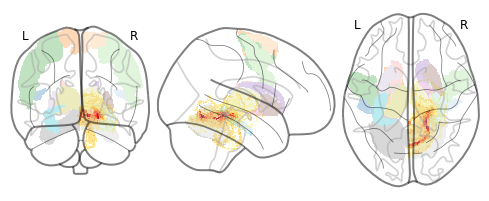

In [7]:
mniTemplate = mainProjectFolder+'Atlases/mni_icbm152_nlin_asym_09a/mni_icbm152_t2_tal_nlin_asym_09a.nii.gz'
roi_dir = mainProjectFolder+'Atlases/Derivatives/'

label_file = roi_dir+'min09a_labels.nii.gz'
    
overwrite=True
if ((os.path.exists(label_file)) & (overwrite == False)):
    print('\n Generate label map: done (set overwrite to True to recompute)')
else:
    print('\n Generate label map')
    mni = nighres.io.load_volume(mniTemplate)
    label_map = numpy.zeros(mni.header.get_data_shape())
    for idx,roi in enumerate(rois):
        roi_data = nighres.io.load_volume(roiFolder+roi+'.nii.gz')
        roi_data = nibabel.as_closest_canonical(roi_data).get_fdata()
        label_map = numpy.maximum(label_map,(idx+1)*roi_data)
        
    label_img = nibabel.Nifti1Image(label_map,mni.affine,mni.header)
    nighres.io.save_volume(label_file,label_img)
    
# ideal: plot ROI contours, and overlay the tracts? complicated...    
display = plotting.plot_glass_brain(None,alpha=0.5,black_bg=False)
display.add_overlay(transformed['result'],cmap='YlOrRd',alpha=1.0)
#display.add_contours(label_img,cmap='tab20',alpha=0.7)
display.add_overlay(label_img,cmap='tab20',alpha=0.3)



In [11]:
print(transformed['result'].get_fdata())

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]


sub-001 ROI plots _________________
/home/public/BeatPerception_DWI/Data/Derivatives/sub-001/atlasreg/sub-001_roi-putamen_L_def-img.nii.gz
/home/public/BeatPerception_DWI/Data/Derivatives/sub-001/atlasreg/sub-001_roi-premotor_cortex_L_def-img.nii.gz
/home/public/BeatPerception_DWI/Data/Derivatives/sub-001/atlasreg/sub-001_roi-cerebellum456_R_def-img.nii.gz
/home/public/BeatPerception_DWI/Data/Derivatives/sub-001/atlasreg/sub-001_roi-caudate_R_def-img.nii.gz
/home/public/BeatPerception_DWI/Data/Derivatives/sub-001/atlasreg/sub-001_roi-sma_R_def-img.nii.gz
/home/public/BeatPerception_DWI/Data/Derivatives/sub-001/atlasreg/sub-001_roi-putamen_R_def-img.nii.gz
/home/public/BeatPerception_DWI/Data/Derivatives/sub-001/atlasreg/sub-001_roi-caudate_L_def-img.nii.gz
/home/public/BeatPerception_DWI/Data/Derivatives/sub-001/atlasreg/sub-001_roi-auditory_cortex_L_def-img.nii.gz
/home/public/BeatPerception_DWI/Data/Derivatives/sub-001/atlasreg/sub-001_roi-gpi_L_def-img.nii.gz
/home/public/BeatPercep

/home/public/BeatPerception_DWI/Data/Derivatives/sub-010/atlasreg/sub-010_roi-auditory_cortex_L_def-img.nii.gz
sub-011 ROI plots _________________
/home/public/BeatPerception_DWI/Data/Derivatives/sub-011/atlasreg/sub-011_roi-caudate_R_def-img.nii.gz
/home/public/BeatPerception_DWI/Data/Derivatives/sub-011/atlasreg/sub-011_roi-sma_L_def-img.nii.gz
/home/public/BeatPerception_DWI/Data/Derivatives/sub-011/atlasreg/sub-011_roi-putamen_R_def-img.nii.gz
/home/public/BeatPerception_DWI/Data/Derivatives/sub-011/atlasreg/sub-011_roi-cerebellum456_L_def-img.nii.gz
/home/public/BeatPerception_DWI/Data/Derivatives/sub-011/atlasreg/sub-011_roi-premotor_cortex_R_def-img.nii.gz
/home/public/BeatPerception_DWI/Data/Derivatives/sub-011/atlasreg/sub-011_roi-cerebellum456_R_def-img.nii.gz
/home/public/BeatPerception_DWI/Data/Derivatives/sub-011/atlasreg/sub-011_roi-auditory_cortex_R_def-img.nii.gz
/home/public/BeatPerception_DWI/Data/Derivatives/sub-011/atlasreg/sub-011_roi-premotor_cortex_L_def-img.nii.

/home/public/BeatPerception_DWI/Data/Derivatives/sub-015/atlasreg/sub-015_roi-auditory_cortex_L_def-img.nii.gz
/home/public/BeatPerception_DWI/Data/Derivatives/sub-015/atlasreg/sub-015_roi-caudate_R_def-img.nii.gz
/home/public/BeatPerception_DWI/Data/Derivatives/sub-015/atlasreg/sub-015_roi-cerebellum456_R_def-img.nii.gz
/home/public/BeatPerception_DWI/Data/Derivatives/sub-015/atlasreg/sub-015_roi-sma_L_def-img.nii.gz
sub-016 ROI plots _________________
/home/public/BeatPerception_DWI/Data/Derivatives/sub-016/atlasreg/sub-016_roi-thalamus_R_def-img.nii.gz
/home/public/BeatPerception_DWI/Data/Derivatives/sub-016/atlasreg/sub-016_roi-gpi_L_def-img.nii.gz
/home/public/BeatPerception_DWI/Data/Derivatives/sub-016/atlasreg/sub-016_roi-premotor_cortex_R_def-img.nii.gz
/home/public/BeatPerception_DWI/Data/Derivatives/sub-016/atlasreg/sub-016_roi-putamen_L_def-img.nii.gz
/home/public/BeatPerception_DWI/Data/Derivatives/sub-016/atlasreg/sub-016_roi-thalamus_L_def-img.nii.gz
/home/public/BeatPerc

/home/public/BeatPerception_DWI/Data/Derivatives/sub-022/atlasreg/sub-022_roi-cerebellum456_L_def-img.nii.gz
/home/public/BeatPerception_DWI/Data/Derivatives/sub-022/atlasreg/sub-022_roi-auditory_cortex_L_def-img.nii.gz
/home/public/BeatPerception_DWI/Data/Derivatives/sub-022/atlasreg/sub-022_roi-gpi_R_def-img.nii.gz
/home/public/BeatPerception_DWI/Data/Derivatives/sub-022/atlasreg/sub-022_roi-gpi_L_def-img.nii.gz
/home/public/BeatPerception_DWI/Data/Derivatives/sub-022/atlasreg/sub-022_roi-auditory_cortex_R_def-img.nii.gz
/home/public/BeatPerception_DWI/Data/Derivatives/sub-022/atlasreg/sub-022_roi-putamen_L_def-img.nii.gz
/home/public/BeatPerception_DWI/Data/Derivatives/sub-022/atlasreg/sub-022_roi-sma_L_def-img.nii.gz
sub-023 ROI plots _________________
/home/public/BeatPerception_DWI/Data/Derivatives/sub-023/atlasreg/sub-023_roi-gpi_L_def-img.nii.gz
/home/public/BeatPerception_DWI/Data/Derivatives/sub-023/atlasreg/sub-023_roi-premotor_cortex_R_def-img.nii.gz
/home/public/BeatPercep

/home/public/BeatPerception_DWI/Data/Derivatives/sub-033/atlasreg/sub-033_roi-cerebellum456_R_def-img.nii.gz
/home/public/BeatPerception_DWI/Data/Derivatives/sub-033/atlasreg/sub-033_roi-sma_R_def-img.nii.gz
/home/public/BeatPerception_DWI/Data/Derivatives/sub-033/atlasreg/sub-033_roi-sma_L_def-img.nii.gz
/home/public/BeatPerception_DWI/Data/Derivatives/sub-033/atlasreg/sub-033_roi-auditory_cortex_R_def-img.nii.gz
/home/public/BeatPerception_DWI/Data/Derivatives/sub-033/atlasreg/sub-033_roi-gpi_R_def-img.nii.gz
/home/public/BeatPerception_DWI/Data/Derivatives/sub-033/atlasreg/sub-033_roi-gpi_L_def-img.nii.gz
/home/public/BeatPerception_DWI/Data/Derivatives/sub-033/atlasreg/sub-033_roi-premotor_cortex_R_def-img.nii.gz
/home/public/BeatPerception_DWI/Data/Derivatives/sub-033/atlasreg/sub-033_roi-auditory_cortex_L_def-img.nii.gz
/home/public/BeatPerception_DWI/Data/Derivatives/sub-033/atlasreg/sub-033_roi-thalamus_R_def-img.nii.gz
/home/public/BeatPerception_DWI/Data/Derivatives/sub-033/a

KeyboardInterrupt: 

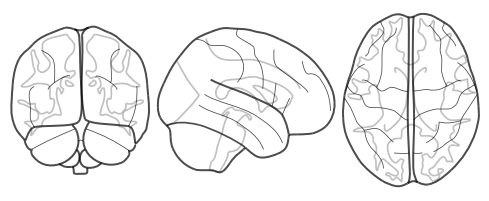

In [8]:
for subject in subjects:
    print(subject+' ROI plots _________________')
    path = work_dir = outputFolder+subject+'/atlasreg/'+subject+'_roi*.gz'
    files = glob.glob(path)
    for f in files:
        #make glass brain plot
        shortFile = os.path.basename(f)
        print(f)
        plotFilesTracts = plotFolder+'ROIs/'+shortFile
        display = plotting.plot_glass_brain(f,output_file=plotFilesTracts+'.pdf',title=shortFile)

### Plot tracts


sub-001 tract plots _________________
/home/public/BeatPerception_DWI/Data/Derivatives/sub-001/selected-tracts/sub-001_tract-thalamus_L_to_sma_L.nii.gz
/home/public/BeatPerception_DWI/Data/Derivatives/sub-001/selected-tracts/sub-001_tract-thalamus_R_to_auditory_cortex_R.nii.gz


KeyboardInterrupt: 

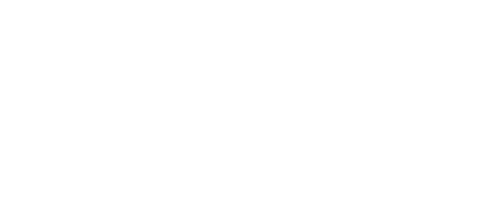

In [3]:
for subject in subjects:
    print(subject+' tract plots _________________')
    path = outputFolder+subject+'/selected-tracts/*.gz'
    files = glob.glob(path)
    for f in files:
        #make glass brain plot
        shortFile = os.path.basename(f)
        print(f)
        plotFilesTracts = plotFolder+'Tracts/'+shortFile
        display = plotting.plot_glass_brain(f,output_file=plotFilesTracts+'.pdf',title=shortFile)

## Calculate average tracts
            

In [34]:
#pairs = pairs[0:2]# for testing
for pair in pairs:
    print('tract between '+pair[0]+' and '+pair[1])
    count = 0
    for subject in subjects:
        print('subject '+subject)
        file = outputFolder+subject+'/selected-tracts/'+subject+'_tract-'+pair[0]+'_to_'+pair[1]+'.nii.gz'
        shortFile = os.path.basename(file)
        print(file)
        plotFilesTracts = plotFolder+'Tracts/'+shortFile
        maskimg = nighres.io.load_volume(file).get_fdata()
        maskimg = numpy.expand_dims(maskimg,axis=0)

        if count ==0:
            tractStack = maskimg
        else:
            tractStack = numpy.concatenate((tractStack,maskimg),axis=0)
        print('size tractStack: ')
        print(tractStack.shape)
        count = count+1
    avgTract = numpy.average(tractStack,axis=0) #calculate the average over subjects for this region
    maskimg = nighres.io.load_volume(file) # load temporary nifti file
    avgimg = nibabel.Nifti1Image(avgTract, maskimg.affine) # replace data with average array
    nibabel.save(avgimg, avgFolder+'Average_'+pair[0]+'_to_'+pair[1]+'.nii.gz')
    plotting.plot_glass_brain(avgimg,output_file=plotFolder+'Tracts/Averages/Average_'+pair[0]+'_to_'+pair[1]+'.pdf',title='Average_'+pair[0]+'_to_'+pair[1])
    

tract between premotor_cortex_L and auditory_cortex_L
subject sub-001
/home/public/BeatPerception_DWI/Data/Derivatives/sub-001/selected-tracts/sub-001_tract-premotor_cortex_L_to_auditory_cortex_L.nii.gz
size tractStack: 
(1, 160, 160, 100)
subject sub-006
/home/public/BeatPerception_DWI/Data/Derivatives/sub-006/selected-tracts/sub-006_tract-premotor_cortex_L_to_auditory_cortex_L.nii.gz
size tractStack: 
(2, 160, 160, 100)
subject sub-008
/home/public/BeatPerception_DWI/Data/Derivatives/sub-008/selected-tracts/sub-008_tract-premotor_cortex_L_to_auditory_cortex_L.nii.gz
size tractStack: 
(3, 160, 160, 100)
subject sub-009
/home/public/BeatPerception_DWI/Data/Derivatives/sub-009/selected-tracts/sub-009_tract-premotor_cortex_L_to_auditory_cortex_L.nii.gz
size tractStack: 
(4, 160, 160, 100)
subject sub-010
/home/public/BeatPerception_DWI/Data/Derivatives/sub-010/selected-tracts/sub-010_tract-premotor_cortex_L_to_auditory_cortex_L.nii.gz
size tractStack: 
(5, 160, 160, 100)
subject sub-011


size tractStack: 
(44, 160, 160, 100)
subject sub-089
/home/public/BeatPerception_DWI/Data/Derivatives/sub-089/selected-tracts/sub-089_tract-premotor_cortex_L_to_auditory_cortex_L.nii.gz
size tractStack: 
(45, 160, 160, 100)
subject sub-090
/home/public/BeatPerception_DWI/Data/Derivatives/sub-090/selected-tracts/sub-090_tract-premotor_cortex_L_to_auditory_cortex_L.nii.gz
size tractStack: 
(46, 160, 160, 100)
subject sub-091
/home/public/BeatPerception_DWI/Data/Derivatives/sub-091/selected-tracts/sub-091_tract-premotor_cortex_L_to_auditory_cortex_L.nii.gz
size tractStack: 
(47, 160, 160, 100)
subject sub-095
/home/public/BeatPerception_DWI/Data/Derivatives/sub-095/selected-tracts/sub-095_tract-premotor_cortex_L_to_auditory_cortex_L.nii.gz
size tractStack: 
(48, 160, 160, 100)
subject sub-103
/home/public/BeatPerception_DWI/Data/Derivatives/sub-103/selected-tracts/sub-103_tract-premotor_cortex_L_to_auditory_cortex_L.nii.gz
size tractStack: 
(49, 160, 160, 100)
tract between premotor_cort

size tractStack: 
(39, 160, 160, 100)
subject sub-078
/home/public/BeatPerception_DWI/Data/Derivatives/sub-078/selected-tracts/sub-078_tract-premotor_cortex_R_to_auditory_cortex_R.nii.gz
size tractStack: 
(40, 160, 160, 100)
subject sub-082
/home/public/BeatPerception_DWI/Data/Derivatives/sub-082/selected-tracts/sub-082_tract-premotor_cortex_R_to_auditory_cortex_R.nii.gz
size tractStack: 
(41, 160, 160, 100)
subject sub-083
/home/public/BeatPerception_DWI/Data/Derivatives/sub-083/selected-tracts/sub-083_tract-premotor_cortex_R_to_auditory_cortex_R.nii.gz
size tractStack: 
(42, 160, 160, 100)
subject sub-084
/home/public/BeatPerception_DWI/Data/Derivatives/sub-084/selected-tracts/sub-084_tract-premotor_cortex_R_to_auditory_cortex_R.nii.gz
size tractStack: 
(43, 160, 160, 100)
subject sub-086
/home/public/BeatPerception_DWI/Data/Derivatives/sub-086/selected-tracts/sub-086_tract-premotor_cortex_R_to_auditory_cortex_R.nii.gz
size tractStack: 
(44, 160, 160, 100)
subject sub-089
/home/publi

FileNotFoundError: [Errno 2] No such file or directory: '/home/public/BeatPerception_DWI/Plots/Tracts/Averages/Average_premotor_cortex_R_to_auditory_cortex_R.pdf'

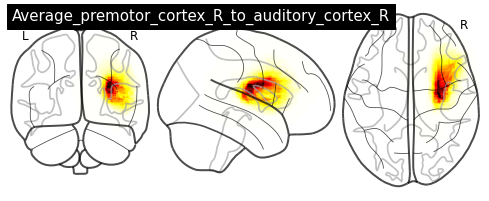

In [39]:
    plotting.plot_glass_brain(avgimg,output_file=plotFolder+'Tracts/Averages/Average_'+pair[0]+'_to_'+pair[1]+'.pdf',title='Average_'+pair[0]+'_to_'+pair[1])
